# AI-Driven Predictive Risk Model for AEC Projects: A Deep Dive

**Welcome to the AI-Powered Future of AEC Risk Management!**

This notebook provides a comprehensive, step-by-step guide to building an intelligent risk prediction model specifically designed for Architecture, Engineering, and Construction (AEC) projects. We'll explore how Artificial Intelligence, particularly Generative AI, can revolutionize traditional risk assessment methods in the AEC industry.

**Why AI in AEC Risk Management?**

AEC projects are inherently complex and fraught with risks. Delays, budget overruns, safety hazards, and quality issues are common challenges that can significantly impact project success. Traditional risk management often relies on manual processes and subjective assessments, which can be time-consuming and prone to biases. 

AI offers a powerful solution by:
   * **Automating Risk Assessment:** AI can process vast datasets and identify patterns that humans might miss, leading to faster and more efficient risk analysis.
   * **Enhancing Accuracy and Objectivity:** AI algorithms can provide data-driven insights, reducing reliance on subjective opinions and improving the accuracy of risk predictions.
   * **Proactive Risk Mitigation:** By predicting potential risks early in the project lifecycle, AI enables proactive risk mitigation strategies, saving time and resources.
   * **Unlocking Qualitative Insights:** Generative AI allows us to extract valuable information from textual data, such as risk descriptions, providing a richer understanding of project risks.

---

**Webinar Workflow Overview:**

We will guide you through the following key stages to build our AI-driven risk model:

1. **Environment Setup & API Key Security:** We'll start by setting up our coding environment and securely managing the OpenAI API key.
2. **AEC Project Risk Dataset: Exploration & Understanding:** We'll load and explore a realistic dataset of AEC project risks, getting familiar with its features and characteristics.
3. **Quantifying Risk: Basic Risk Score Calculation:** We'll create a baseline risk score using traditional quantitative project features.
4. **Unleashing Generative AI: Enhancing Risk Assessment:** This is where the magic happens! We'll integrate Generative AI to:
    * **Refine the Basic Risk Score:** Use AI to add nuanced understanding to our initial risk score.
    * **Extract Risk Sentiment:** Leverage AI to gauge the sentiment expressed in risk descriptions.
    * **Categorize Risks:** Automatically classify risks into meaningful categories using AI.
    * **Determine Urgency Levels:** Let AI assess the urgency associated with each risk.
5. **Building Predictive Models: From Basic to Advanced:** We'll build and compare two predictive models:
    * **Model 1: Comprehensive Risk Prediction (Full Feature Set):** Utilizing all available features, including AI-generated ones, to predict `RiskOccurred`.
    * **Model 2: Robust Risk Prediction (Reduced Feature Set):** Focusing on a leaner model, excluding potentially 'leaky' AI-derived features to ensure real-world applicability.
6. **Testing and Validation: Predicting New Project Risks:** We'll put our models to the test by predicting the risk outcome for a hypothetical, new AEC project.
7. **Visualizing Insights: Data Analysis & Actionable Intelligence:** Finally, we'll delve into data analysis and visualization techniques to extract actionable insights and understand what drives risk in AEC projects.

**Classification Goal:**

Our primary objective is to build a classification model that accurately predicts whether a significant risk event (**RiskOccurred**) will occur in an AEC project. A prediction of `1` indicates a high likelihood of a risk event, enabling project managers to take proactive steps to mitigate potential issues.

Let's embark on this exciting journey into AI-driven risk management!

## 1. Environment Setup and Secure API Key Management

To begin, we need to set up our coding environment and securely handle the OpenAI API key.  

**Prerequisites:**
* **Python Libraries:** Ensure you have the necessary Python libraries installed. You can install them using `pip install -r requirements.txt` (if you have a `requirements.txt` file) or individually install libraries like `os`, `dotenv`, `pandas`, `numpy`, `openai`, `scikit-learn`, `matplotlib`, `seaborn`, etc.
* **OpenAI API Key:** You'll need an OpenAI API key to access the Generative AI models. If you don't have one, you can create an account and obtain an API key from the [OpenAI website](https://platform.openai.com/).

**Secure API Key Storage:**

It's crucial to keep your API key secure and avoid hardcoding it directly into your notebook. We'll use a `.env` file to store the API key as an environment variable.

**Steps:**
1. **Create `.env` file:** In the same directory as your notebook, create a new file named `.env`.
2. **Add API Key to `.env`:** Open the `.env` file and add the following line, replacing `sk-xxxxxxxxxxxxxxxxxxxxxxxxxxxxx` with your actual OpenAI API key:

```
OPENAI_API_KEY=sk-xxxxxxxxxxxxxxxxxxxxxxxxxxxxx
```

**Important:** Make sure to **never** commit your `.env` file to version control (like Git) to prevent exposing your API key publicly. Add `.env` to your `.gitignore` file.

In [1]:
# Import required libraries
import os                             # For environment variable access
from dotenv import load_dotenv        # To load environment variables from a .env file
import pandas as pd                   # For data manipulation and CSV reading
import numpy as np                    # For numerical operations
import time                           # For adding delays (e.g., API rate limits)
import logging                        # For logging messages
import openai                         # For interacting with OpenAI's API
import matplotlib.pyplot as plt       # For plotting graphs
import seaborn as sns                 # For enhanced visualization
from sklearn.model_selection import train_test_split, cross_val_score  # For data splitting and evaluation
from sklearn.ensemble import RandomForestClassifier   # For building the predictive model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc  # For model evaluation
from tqdm import tqdm # For progress bars

# Configure logging for detailed output
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Load environment variables from the .env file
load_dotenv()

# Retrieve the OpenAI API key from the environment variable
openai_api_key = os.environ.get('OPENAI_API_KEY')
if openai_api_key is None:
    raise ValueError("Please set the OPENAI_API_KEY environment variable in your .env file.")
logger.info("OpenAI API key loaded successfully. Key starts with: %s", openai_api_key[:5])

# Set the API key for the openai library
openai.api_key = openai_api_key

# Import the new OpenAI client and create a client instance
from openai import OpenAI
client = OpenAI(api_key=openai_api_key)

2025-03-09 03:00:44,886 - INFO - OpenAI API key loaded successfully. Key starts with: sk-pr


## 2. Defining Generative AI Functions for Enhanced Risk Assessment

Now, let's define the core functions that leverage Generative AI to enhance our risk model. We'll create four functions using OpenAI's ChatCompletion API (specifically the `gpt-3.5-turbo` model) to extract qualitative insights from textual risk descriptions:

1. **`get_ai_adjustment(risk_description)`:**  
    * **Purpose:**  To generate a numeric adjustment factor that refines our basic risk score based on the nuanced information present in the risk description. This factor will be greater than 1.0 if the AI assesses the risk as more severe than initially calculated, and 1.0 otherwise.
    * **Output:** A float value representing the adjustment factor.

2. **`get_risk_sentiment(risk_description)`:**  
    * **Purpose:** To determine the sentiment (positive, negative, or neutral) expressed in the risk description. This function will output a sentiment score between 0 and 1, where 0 indicates a very positive or low-risk sentiment, and 1 indicates a very negative or high-risk sentiment.
    * **Output:** A float value between 0 and 1 representing the sentiment score.

3. **`get_risk_type(risk_description)`:**  
    * **Purpose:** To categorize the risk into predefined types based on the risk description. This will help us understand the nature of the risk (e.g., "Material", "Design", "Operational", etc.).
    * **Output:** A categorical label representing the risk type.

4. **`get_urgency_level(risk_description)`:**  
    * **Purpose:** To assess the urgency level of the risk based on its description. This function will categorize the urgency into "Low", "Medium", or "High".
    * **Output:** A categorical label indicating the urgency level.

These functions will act as our interface to Generative AI, allowing us to tap into the power of language models for richer risk insights.

In [2]:
def get_ai_adjustment(risk_description):
    """
    Uses OpenAI's ChatCompletion API to generate an adjustment factor based on the risk description.
    Returns a float (if risk is severe, factor > 1.0; else 1.0).
    """
    prompt = (
        "You are an expert risk assessor. Based on the following risk description, "
        "provide a risk adjustment factor as a numeric value. Return 1.0 if no adjustment is needed, "
        "or a value greater than 1.0 if the risk is more severe. Only output a numeric value.\n\n"
        f"Risk Description: \"{risk_description}\"\n"
        "Adjustment Factor:"
    )
    try:
        completion = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": "You are a knowledgeable risk management expert."},
                {"role": "user", "content": prompt}
            ],
            max_tokens=10,
            temperature=0.5
        )
        adjustment_text = completion.choices[0].message.content.strip()
        adjustment_factor = float(adjustment_text)
        logger.info("Received adjustment factor: %s for description: %s", adjustment_factor, risk_description[:30])
    except Exception as e:
        logger.error("Error in getting AI adjustment: %s", e)
        adjustment_factor = 1.0
    return adjustment_factor

def get_risk_sentiment(risk_description):
    """
    Uses OpenAI's ChatCompletion API to generate a sentiment score for the risk description.
    Returns a float between 0 (very positive/low risk) and 1 (very negative/high risk).
    """
    prompt = (
        "You are an expert risk sentiment analyst. Based on the following risk description, "
        "provide a sentiment score between 0 and 1, where 0 means very positive (low risk) and 1 means very negative (high risk). "
        "Return only a numeric value.\n\n"
        f"Risk Description: \"{risk_description}\"\n"
        "Sentiment Score:"
    )
    try:
        completion = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": "You are an expert risk sentiment analyst."},
                {"role": "user", "content": prompt}
            ],
            max_tokens=10,
            temperature=0.5
        )
        sentiment_text = completion.choices[0].message.content.strip()
        sentiment_score = float(sentiment_text)
        logger.info("Received sentiment score: %s for description: %s", sentiment_score, risk_description[:30])
    except Exception as e:
        logger.error("Error in getting risk sentiment: %s", e)
        sentiment_score = 0.5  # Default neutral sentiment
    return sentiment_score

def get_risk_type(risk_description):
    """
    Uses OpenAI's ChatCompletion API to derive the primary risk type from the risk description.
    Returns a categorical label (e.g., 'Material', 'Design', 'Operational', 'Financial', 'Regulatory', or 'Other').
    """
    prompt = (
        "You are an expert risk analyst. Based on the following risk description, determine the primary type of risk. "
        "Choose from: Material, Design, Operational, Financial, Regulatory, or Other.\n\n"
        f"Risk Description: \"{risk_description}\"\n"
        "Risk Type:"
    )
    try:
        completion = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": "You are a seasoned risk analyst."},
                {"role": "user", "content": prompt}
            ],
            max_tokens=10,
            temperature=0.5
        )
        risk_type = completion.choices[0].message.content.strip()
        logger.info("Generated RiskType: %s for description: %s", risk_type, risk_description[:30])
    except Exception as e:
        logger.error("Error in generating RiskType: %s", e)
        risk_type = "Other"
    return risk_type

def get_urgency_level(risk_description):
    """
    Uses OpenAI's ChatCompletion API to derive an urgency level from the risk description.
    Returns a categorical label: 'Low', 'Medium', or 'High'.
    """
    prompt = (
        "You are an expert risk analyst. Based on the following risk description, determine the urgency level of the risk. "
        "Choose from: Low, Medium, or High.\n\n"
        f"Risk Description: \"{risk_description}\"\n"
        "Urgency Level:"
    )
    try:
        completion = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": "You are a seasoned risk analyst."},
                {"role": "user", "content": prompt}
            ],
            max_tokens=10,
            temperature=0.5
        )
        urgency = completion.choices[0].message.content.strip()
        logger.info("Generated UrgencyLevel: %s for description: %s", urgency, risk_description[:30])
    except Exception as e:
        logger.error("Error in generating UrgencyLevel: %s", e)
        urgency = "Medium"
    return urgency

## 3. Load and Explore the AEC Project Risk Dataset

Let's load our dataset, `project_risk_data.csv`, which contains realistic data for AEC projects and potential risks. We will then explore the dataset to understand its structure, features, and data types.

**Dataset Columns:**

The dataset includes the following columns, designed to represent key aspects of AEC projects that can influence risk:

- **ProjectID:** Unique identifier for each project.
- **Duration:**  Project duration in days (ranging from 30 to 700 days).
- **BudgetVariance:**  Budget variance, representing the difference between the planned and actual budget (in thousands of dollars). Positive values indicate overruns, negative values underruns.
- **TeamExperience:** Average experience level of the project team (in years).
- **ProjectSize:**  Size of the project (e.g., in square meters).
- **DesignComplexity:** A numerical score (1-5) indicating the complexity of the project design.
- **SubcontractorReliability:** A score (1-5, lower is less reliable) assessing the reliability of subcontractors involved.
- **RiskOccurred:**  Our target variable! A binary indicator: `1` if a significant risk event occurred during the project, `0` otherwise.
- **RiskDescription:**  A text description providing details about the risk event (or lack thereof).

Let's load the data and take a peek at the first few rows to get a feel for the dataset.

In [3]:
# Load the dataset from CSV
data = pd.read_csv('project_risk_data.csv')
logger.info("Dataset loaded successfully. Total rows: %d", len(data))
print("Dataset Head:")
print(data.head())

# Check for missing values
print("Missing Values:")
print(data.isnull().sum())

2025-03-09 03:00:44,919 - INFO - Dataset loaded successfully. Total rows: 129


Dataset Head:
  ProjectID  Duration  BudgetVariance  TeamExperience  ProjectSize  \
0        P1        45              12               4         1500   
1        P2       120              20               6         8000   
2        P3       200              35               7        15000   
3        P4        60              10               5         3000   
4        P5       350              40               8        25000   

   DesignComplexity  SubcontractorReliability  RiskOccurred  \
0                 2                         4             1   
1                 3                         3             0   
2                 4                         2             1   
3                 2                         5             0   
4                 5                         2             1   

                                     RiskDescription  
0   Material delivery delays due to supplier issues.  
1  Project progressing on schedule with stable fu...  
2  Unexpected budget 

## 4. Computing the Basic Risk Score

To establish a quantitative baseline for risk assessment, we'll compute a "Basic Risk Score" for each project. This score will be calculated using a formula that combines several key quantitative features from our dataset, reflecting common risk factors in AEC projects.

**Basic Risk Score Formula:**

$$
\text{BasicRiskScore} = \text{BudgetVariance} \times (6 - \text{TeamExperience}) \times \text{DesignComplexity} \times (6 - \text{SubcontractorReliability}) \times \left(\frac{\text{ProjectSize}}{10000}\right)
$$

**Formula Rationale:**
* **BudgetVariance:** Higher budget variance (especially overruns) directly increases risk.
* **(6 - TeamExperience):** Less experienced teams are generally associated with higher project risks. We subtract `TeamExperience` from 6 (a constant greater than the max experience to ensure positive contribution) so that lower experience results in a higher score.
* **DesignComplexity:** More complex designs inherently carry greater risks.
* **(6 - SubcontractorReliability):** Lower subcontractor reliability increases project risk. Similar to TeamExperience, we invert the SubcontractorReliability score so that lower reliability contributes to a higher risk score.
* **ProjectSize / 10000:** Larger projects are generally more complex and prone to risks. We scale down `ProjectSize` by 10000 to manage the magnitude of its contribution to the score.

This formula is a simplified representation of risk and serves as a starting point. We will later refine this score using Generative AI.

In [4]:
# Calculate the basic risk score for each project
data['BasicRiskScore'] = (
    data['BudgetVariance'] *
    (6 - data['TeamExperience']) *
    data['DesignComplexity'] *
    (6 - data['SubcontractorReliability']) *
    (data['ProjectSize'] / 10000)
)
print("Basic Risk Scores (first 5 rows):")
print(data[['ProjectID', 'BasicRiskScore']].head())

Basic Risk Scores (first 5 rows):
  ProjectID  BasicRiskScore
0        P1            14.4
1        P2             0.0
2        P3          -840.0
3        P4             6.0
4        P5         -4000.0


## 5. Refining the Risk Score with Generative AI & Deriving Qualitative Features

Here, we enhance our basic risk assessment by integrating qualitative insights from the `RiskDescription` column using Generative AI. We'll use the functions we defined earlier to:

1. **Refine the Basic Risk Score:** We'll use the `get_ai_adjustment` function to obtain an AI-driven adjustment factor and multiply it with the `BasicRiskScore` to create a `RefinedRiskScore`.
2. **Derive Risk Sentiment:** We'll use the `get_risk_sentiment` function to generate a `RiskSentiment` score (0 to 1) from the `RiskDescription`, capturing the perceived negativity or risk level expressed in the text.
3. **Extract Categorical Risk Features:** We'll employ the `get_risk_type` and `get_urgency_level` functions to automatically categorize each risk description into `RiskType` and `UrgencyLevel` categories.

These AI-derived features will add valuable qualitative dimensions to our risk model, allowing it to consider the descriptive context of each risk event.

In [5]:
# Refine risk score using generative AI and track progress
tqdm.pandas(desc="Refining Risk Scores with AI")
data['RefinedRiskScore'] = data['RiskDescription'].progress_apply(get_ai_adjustment)
print("Refined Risk Scores (first 5 rows):")
print(data[['ProjectID', 'BasicRiskScore', 'RefinedRiskScore']].head())

# Compute risk sentiment using generative AI and track progress
tqdm.pandas(desc="Calculating Risk Sentiment with AI")
data['RiskSentiment'] = data['RiskDescription'].progress_apply(get_risk_sentiment)
print("Risk Sentiment Scores (first 5 rows):")
print(data[['ProjectID', 'RiskSentiment']].head())

# Generate RiskType using generative AI and track progress
tqdm.pandas(desc="Generating Risk Types with AI")
data['RiskType'] = data['RiskDescription'].progress_apply(get_risk_type)
print("RiskType (first 5 rows):")
print(data[['ProjectID', 'RiskType']].head())

# Generate UrgencyLevel using generative AI and track progress
tqdm.pandas(desc="Generating Urgency Levels with AI")
data['UrgencyLevel'] = data['RiskDescription'].progress_apply(get_urgency_level)
print("UrgencyLevel (first 5 rows):")
print(data[['ProjectID', 'UrgencyLevel']].head())

Refining Risk Scores with AI:   0%|          | 0/129 [00:00<?, ?it/s]2025-03-09 03:00:46,603 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-09 03:00:46,609 - INFO - Received adjustment factor: 1.2 for description: Material delivery delays due t
Refining Risk Scores with AI:   2%|▏         | 2/129 [00:01<01:45,  1.20it/s]2025-03-09 03:00:47,487 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-09 03:00:47,491 - INFO - Received adjustment factor: 1.0 for description: Project progressing on schedul
Refining Risk Scores with AI:   2%|▏         | 3/129 [00:02<01:47,  1.17it/s]2025-03-09 03:00:48,134 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-09 03:00:48,142 - INFO - Received adjustment factor: 1.2 for description: Unexpected budget overruns due
Refining Risk Scores with AI:   3%|▎         | 4/129 [00:03<01:37,  1.28it/s]2025-03-09 03:00:48,77

Refined Risk Scores (first 5 rows):
  ProjectID  BasicRiskScore  RefinedRiskScore
0        P1            14.4               1.2
1        P2             0.0               1.0
2        P3          -840.0               1.2
3        P4             6.0               1.0
4        P5         -4000.0               1.2


Calculating Risk Sentiment with AI:   0%|          | 0/129 [00:00<?, ?it/s]2025-03-09 03:02:44,442 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-09 03:02:44,447 - INFO - Received sentiment score: 0.8 for description: Material delivery delays due t
Calculating Risk Sentiment with AI:   2%|▏         | 2/129 [00:00<00:41,  3.05it/s]2025-03-09 03:02:45,279 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-09 03:02:45,283 - INFO - Received sentiment score: 0.1 for description: Project progressing on schedul
Calculating Risk Sentiment with AI:   2%|▏         | 3/129 [00:01<01:07,  1.85it/s]2025-03-09 03:02:45,879 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-09 03:02:45,887 - INFO - Received sentiment score: 0.8 for description: Unexpected budget overruns due
Calculating Risk Sentiment with AI:   3%|▎         | 4/129 [00:02<01:10,  1.77it/s]2025

Risk Sentiment Scores (first 5 rows):
  ProjectID  RiskSentiment
0        P1            0.8
1        P2            0.1
2        P3            0.8
3        P4            0.1
4        P5            0.8


Generating Risk Types with AI:   0%|          | 0/129 [00:00<?, ?it/s]2025-03-09 03:04:21,207 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-09 03:04:21,212 - INFO - Generated RiskType: Operational Risk for description: Material delivery delays due t
Generating Risk Types with AI:   2%|▏         | 2/129 [00:00<00:33,  3.77it/s]2025-03-09 03:04:21,909 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-09 03:04:21,914 - INFO - Generated RiskType: Based on the risk description provided, the primary type for description: Project progressing on schedul
Generating Risk Types with AI:   2%|▏         | 3/129 [00:01<00:56,  2.24it/s]2025-03-09 03:04:22,636 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-09 03:04:22,640 - INFO - Generated RiskType: The primary type of risk in this description is Design for description: Unexpected budget overruns due
Gen

RiskType (first 5 rows):
  ProjectID                                           RiskType
0        P1                                   Operational Risk
1        P2  Based on the risk description provided, the pr...
2        P3  The primary type of risk in this description i...
3        P4                                        Operational
4        P5                                             Design


Generating Urgency Levels with AI:   0%|          | 0/129 [00:00<?, ?it/s]2025-03-09 03:06:00,065 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-09 03:06:00,074 - INFO - Generated UrgencyLevel: Based on the risk description provided, the urgency level for description: Material delivery delays due t
Generating Urgency Levels with AI:   2%|▏         | 2/129 [00:01<01:26,  1.47it/s]2025-03-09 03:06:00,785 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-09 03:06:00,799 - INFO - Generated UrgencyLevel: Based on the risk description provided, the urgency level for description: Project progressing on schedul
Generating Urgency Levels with AI:   2%|▏         | 3/129 [00:02<01:27,  1.43it/s]2025-03-09 03:06:02,106 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-09 03:06:02,110 - INFO - Generated UrgencyLevel: Based on the risk description of "Unexpe

UrgencyLevel (first 5 rows):
  ProjectID                                       UrgencyLevel
0        P1  Based on the risk description provided, the ur...
1        P2  Based on the risk description provided, the ur...
2        P3  Based on the risk description of "Unexpected b...
3        P4                                 Urgency Level: Low
4        P5  Based on the risk description provided, the ur...


## 6. Prepare Data for Predictive Modeling

The feature set for the predictive model includes:

* `Duration`
* `BudgetVariance`
* `TeamExperience`
* `ProjectSize`
* `DesignComplexity`
* `SubcontractorReliability`
* `RefinedRiskScore`
* `RiskSentiment`
* `RiskType`
* `UrgencyLevel`

The target variable is **RiskOccurred** (1 if a risk event occurred, 0 otherwise).

Due to potential data leakage from RefinedRiskScore and RiskSentiment, we will train two models:

- **Model 1 (Full Feature Set):** Uses all features, including those derived from generative AI: `Duration, BudgetVariance, TeamExperience, ProjectSize, DesignComplexity, SubcontractorReliability, RefinedRiskScore, RiskSentiment, RiskType, UrgencyLevel`

- **Model 2 (Reduced Feature Set):** Excludes the directly derived features that might cause data leakage (`RefinedRiskScore` and `RiskSentiment`), using: `Duration, BudgetVariance, TeamExperience, ProjectSize, DesignComplexity, SubcontractorReliability, RiskType, UrgencyLevel`

We use one-hot encoding for categorical features.

In [6]:
# One-hot encode categorical features: RiskType and UrgencyLevel
data_encoded = pd.get_dummies(data, columns=['RiskType', 'UrgencyLevel'], drop_first=True)

# Define features for Model 1 (full feature set)
features_model1 = ['Duration', 'BudgetVariance', 'TeamExperience', 'ProjectSize', 
                   'DesignComplexity', 'SubcontractorReliability', 'RefinedRiskScore', 'RiskSentiment'] \
                   + [col for col in data_encoded.columns if col.startswith("RiskType_") or col.startswith("UrgencyLevel_")]
X_model1 = data_encoded[features_model1]
y = data_encoded['RiskOccurred']

# Split Model 1 data into training (85%) and testing (15%) sets
X_train1, X_test1, y_train, y_test = train_test_split(X_model1, y, test_size=0.15, random_state=274)
logger.info("Model 1 data split into training and testing sets.")

# Define features for Model 2 (reduced feature set, excluding RefinedRiskScore and RiskSentiment)
features_model2 = ['Duration', 'BudgetVariance', 'TeamExperience', 'ProjectSize', 
                   'DesignComplexity', 'SubcontractorReliability'] \
                   + [col for col in data_encoded.columns if col.startswith("RiskType_") or col.startswith("UrgencyLevel_")]
X_model2 = data_encoded[features_model2]

# Split Model 2 data - IMPORTANT: Use X_model2, not X_model1 here
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_model2, y, test_size=0.15, random_state=274)

2025-03-09 03:07:45,988 - INFO - Model 1 data split into training and testing sets.


## 7. Build and Evaluate Predictive Models

We build and evaluate two Random Forest models:

- **Model 1 (Full Feature Set):** Uses all features (quantitative and qualitative).  
  *Evaluation:* Held-out test set.

- **Model 2 (Reduced Feature Set):** Excludes the direct qualitative features (RefinedRiskScore and RiskSentiment) to avoid data leakage.  
  *Evaluation:* 5-fold cross-validation.

**Note on Overfitting:** If you notice that your evaluation scores (accuracy, etc.) are equal to 1, this may indicate overfitting or data leakage. In the next cell, we provide additional diagnostics and visualizations (such as confusion matrices and ROC curves) to help identify and address this issue. Consider reducing model complexity (e.g., setting `max_depth`) or performing hyperparameter tuning.

In [7]:
# Model 1: Train on full feature set
rf_model1 = RandomForestClassifier(n_estimators=100, random_state=274)
rf_model1.fit(X_train1, y_train)
logger.info("Model 1 (full feature set) trained.")

# Evaluate Model 1 on the test set
y_pred1 = rf_model1.predict(X_test1)
accuracy_model1 = accuracy_score(y_test, y_pred1)
logger.info("Model 1 Accuracy (full feature set): %.2f", accuracy_model1)
print("Model 1 Accuracy (full feature set):", accuracy_model1)
print("Classification Report for Model 1:\n", classification_report(y_test, y_pred1))

# Model 2: Evaluate using 5-fold cross-validation to avoid leakage
rf_model2 = RandomForestClassifier(n_estimators=100, random_state=274)
rf_model2.fit(X_train2, y_train2)
cv_scores_model2 = cross_val_score(rf_model2, X_train2, y_train2, cv=5, scoring='accuracy')
logger.info("Cross-validated accuracy for Model 2 (reduced feature set): %.2f", cv_scores_model2.mean())
print("Cross-validated accuracy for Model 2 (reduced feature set):", cv_scores_model2.mean())

2025-03-09 03:07:46,053 - INFO - Model 1 (full feature set) trained.
2025-03-09 03:07:46,056 - INFO - Model 1 Accuracy (full feature set): 1.00


Model 1 Accuracy (full feature set): 1.0
Classification Report for Model 1:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00        11

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



2025-03-09 03:07:46,323 - INFO - Cross-validated accuracy for Model 2 (reduced feature set): 0.99


Cross-validated accuracy for Model 2 (reduced feature set): 0.990909090909091


### 7.1. Debugging Overfitting & Additional Evaluation Metrics

In this section, we add further diagnostics to ensure that our models are not overfitting. We include:

- **Confusion Matrix:** To observe the distribution of correct and incorrect classifications.
- **ROC Curve and AUC:** To evaluate the model's discrimination ability on unseen data.
- **Target Variable Distribution:** To check if the dataset is imbalanced which might lead to misleading high accuracy scores.

These additional metrics will help us understand and address any potential issues with overfitting.

<Figure size 600x500 with 0 Axes>

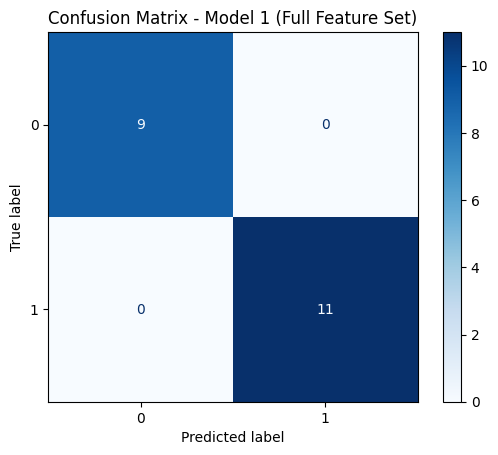

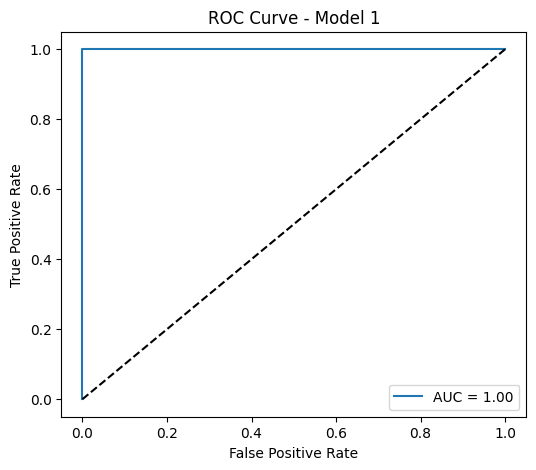

Target variable distribution:
RiskOccurred
1    78
0    51
Name: count, dtype: int64


In [8]:
from sklearn.metrics import ConfusionMatrixDisplay

# Confusion Matrix for Model 1
cm = confusion_matrix(y_test, y_pred1)
plt.figure(figsize=(6, 5))
ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap='Blues')
plt.title('Confusion Matrix - Model 1 (Full Feature Set)')
plt.show()

# ROC Curve for Model 1
y_proba = rf_model1.predict_proba(X_test1)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Model 1')
plt.legend(loc='lower right')
plt.show()

# Check target variable distribution
print("Target variable distribution:")
print(y.value_counts())

## 8. Predict a New Project Risk

Now we test our models with an assumed project. We provide a sample project with realistic features. The models will predict whether this project is likely to experience a risk event.

**Sample Project Features:**
- **Duration:** 200 days
- **BudgetVariance:** 30 (thousands)
- **TeamExperience:** 7 years
- **ProjectSize:** 15000 (e.g., square meters)
- **DesignComplexity:** 4
- **SubcontractorReliability:** 3
- **RiskDescription:** "Delayed approvals and unexpected design modifications causing potential budget overruns."

In [9]:
# Define a sample project as a dictionary
sample_project = {
    'Duration': 200,
    'BudgetVariance': 30,
    'TeamExperience': 7,
    'ProjectSize': 15000,
    'DesignComplexity': 4,
    'SubcontractorReliability': 3,
    'RiskDescription': "Delayed approvals and unexpected design modifications causing potential budget overruns."
}

# Compute basic risk score for the sample project
sample_basic_risk = (
    sample_project['BudgetVariance'] * (6 - sample_project['TeamExperience']) *
    sample_project['DesignComplexity'] * (6 - sample_project['SubcontractorReliability']) *
    (sample_project['ProjectSize'] / 10000)
)

# Get adjustment factor and compute refined risk score
sample_adjustment = get_ai_adjustment(sample_project['RiskDescription'])
sample_refined_risk = sample_basic_risk * sample_adjustment

# Get risk sentiment
sample_sentiment = get_risk_sentiment(sample_project['RiskDescription'])

# Get categorical features from generative AI
sample_risk_type = get_risk_type(sample_project['RiskDescription'])
sample_urgency = get_urgency_level(sample_project['RiskDescription'])

# Log the computed sample values
logger.info("Sample Basic Risk Score: %.2f", sample_basic_risk)
logger.info("Sample Refined Risk Score: %.2f", sample_refined_risk)
logger.info("Sample Risk Sentiment: %.2f", sample_sentiment)
logger.info("Sample Risk Type: %s", sample_risk_type)
logger.info("Sample Urgency Level: %s", sample_urgency)

# Create a DataFrame for the sample project
sample_df = pd.DataFrame([{
    'Duration': sample_project['Duration'],
    'BudgetVariance': sample_project['BudgetVariance'],
    'TeamExperience': sample_project['TeamExperience'],
    'ProjectSize': sample_project['ProjectSize'],
    'DesignComplexity': sample_project['DesignComplexity'],
    'SubcontractorReliability': sample_project['SubcontractorReliability'],
    'RefinedRiskScore': sample_refined_risk,
    'RiskSentiment': sample_sentiment,
    'RiskDescription': sample_project['RiskDescription']  # Not used for prediction
}])

# Generate categorical features for the sample project
sample_df['RiskType'] = sample_df['RiskDescription'].apply(get_risk_type)
sample_df['UrgencyLevel'] = sample_df['RiskDescription'].apply(get_urgency_level)

# One-hot encode categorical features for Model 1
sample_encoded = pd.get_dummies(sample_df, columns=['RiskType', 'UrgencyLevel'], drop_first=True)
# Ensure sample has same columns as Model 1 training data
for col in X_model1.columns:
    if col not in sample_encoded.columns:
        sample_encoded[col] = 0
sample_encoded = sample_encoded[X_model1.columns]

# Predict risk using Model 1 (Full Feature Set)
sample_prediction_model1 = rf_model1.predict(sample_encoded)[0]
print("Model 1 Prediction for Sample Project (Full Feature Set):", sample_prediction_model1)

# For Model 2 (Reduced Feature Set), prepare sample data accordingly
sample_encoded_model2 = pd.get_dummies(sample_df, columns=['RiskType', 'UrgencyLevel'], drop_first=True)
for col in X_model2.columns:
    if col not in sample_encoded_model2.columns:
        sample_encoded_model2[col] = 0
sample_encoded_model2 = sample_encoded_model2[X_model2.columns]

# Train Model 2 and predict the sample (using the Model 2 trained on the reduced feature set)
sample_prediction_model2 = rf_model2.predict(sample_encoded_model2)[0]
print("Model 2 Prediction for Sample Project (Reduced Feature Set):", sample_prediction_model2)

2025-03-09 03:07:47,353 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-09 03:07:47,357 - INFO - Received adjustment factor: 1.2 for description: Delayed approvals and unexpect
2025-03-09 03:07:47,955 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-09 03:07:47,976 - INFO - Received sentiment score: 0.8 for description: Delayed approvals and unexpect
2025-03-09 03:07:48,682 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-09 03:07:48,696 - INFO - Generated RiskType: The primary type of risk based on the description provided for description: Delayed approvals and unexpect
2025-03-09 03:07:49,766 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-09 03:07:49,788 - INFO - Generated UrgencyLevel: Based on the risk description provided, the urgency level for description: Delayed approvals and unexpect
2

Model 1 Prediction for Sample Project (Full Feature Set): 1
Model 2 Prediction for Sample Project (Reduced Feature Set): 1


## 9. Data Analysis and Visualizations: Unveiling Risk Drivers

In this section, we perform additional data analysis to gain insights into project risks.

### Additional Visualizations

Along with the correlation matrix and distribution plots (already shown), we now add:

- **Scatter Plot:** Comparing Basic vs. Refined Risk Scores to see how the AI adjustment affects risk assessment.
- **Feature Importance Visualization:** Already provided, but with enhanced labeling.

These visualizations help in understanding how different features drive the overall risk prediction.

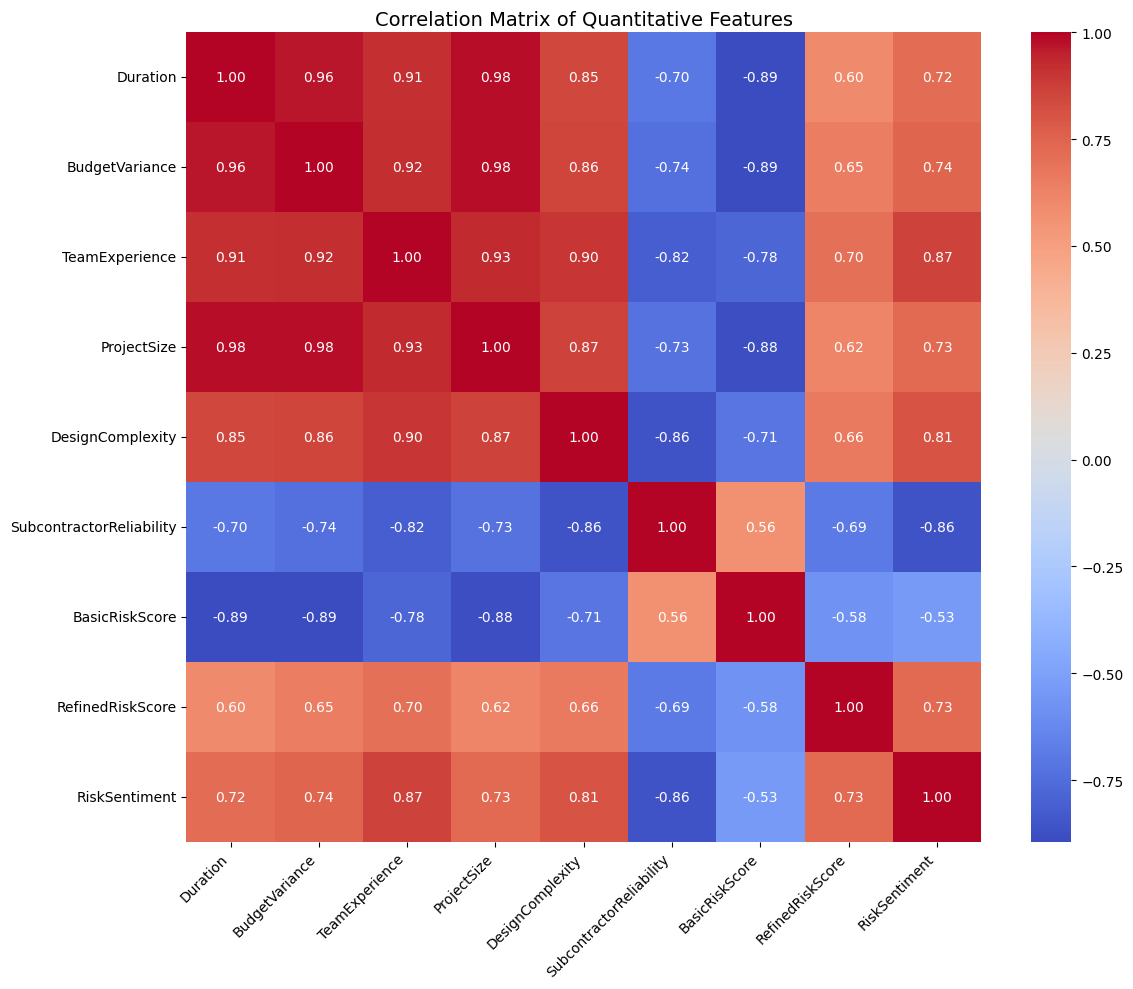

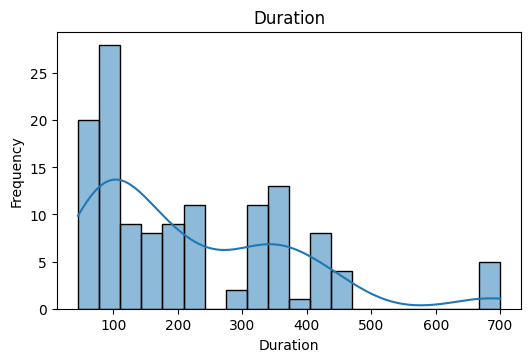

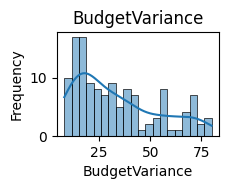

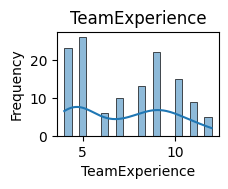

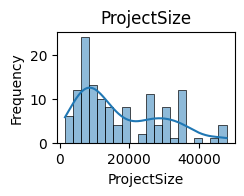

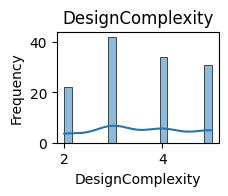

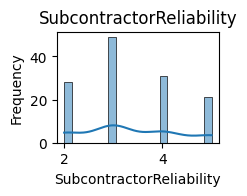

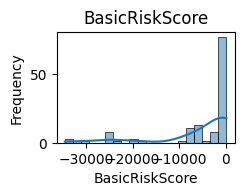

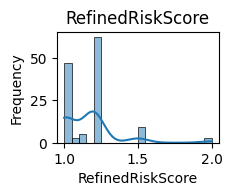

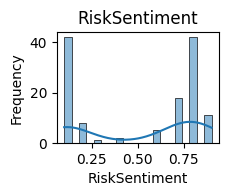

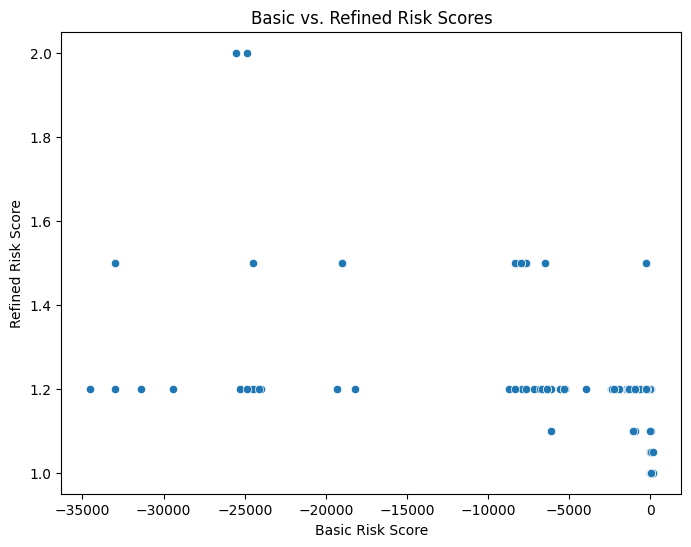

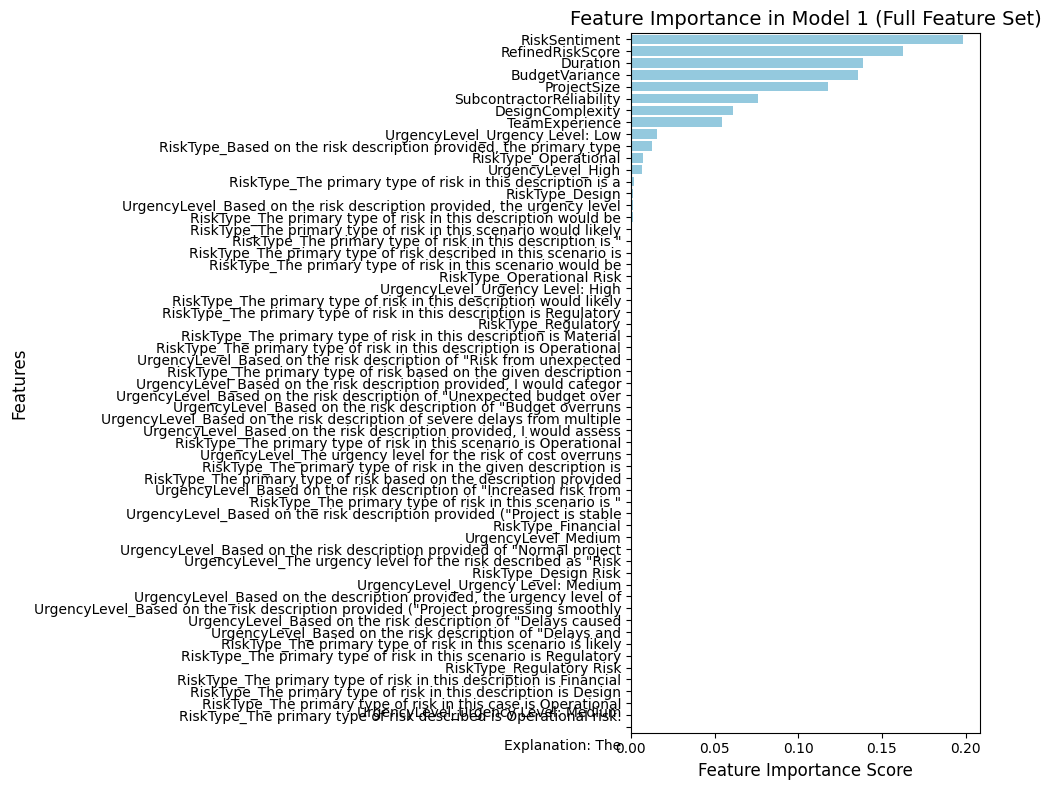

/var/folders/1n/6qwvs6td5td4_8p9w9qv2p700000gn/T/ipykernel_60222/3427757422.py:46: FutureWarning: The provided callable <function mean at 0x104ef3e50> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  pivot_table = data.pivot_table(index='TeamExperience', columns='BudgetVariance', values='RefinedRiskScore', aggfunc=np.mean)


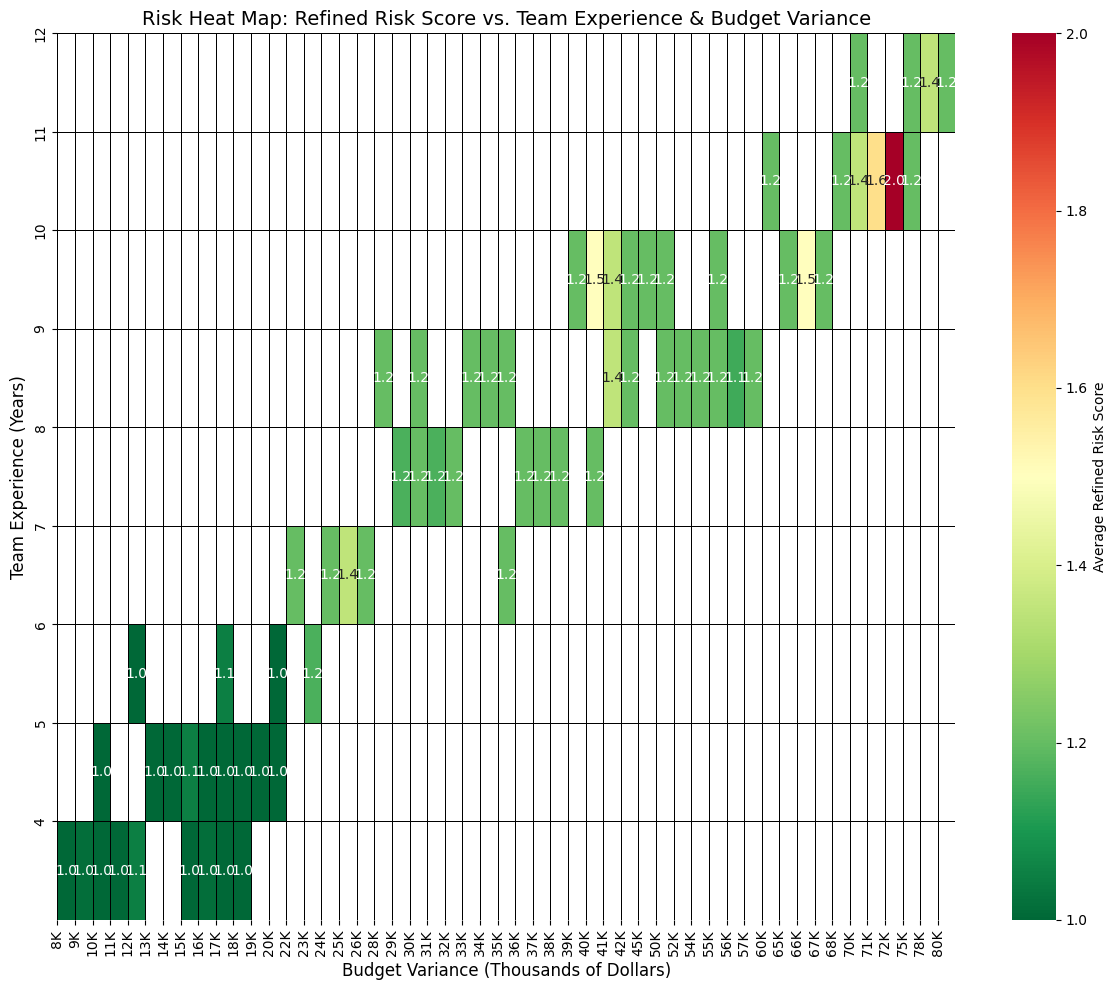

In [10]:
# Correlation Matrix for quantitative features
quant_features = ['Duration', 'BudgetVariance', 'TeamExperience', 'ProjectSize', 'DesignComplexity', 'SubcontractorReliability', 'BasicRiskScore', 'RefinedRiskScore', 'RiskSentiment']
corr_matrix = data[quant_features].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={'fontsize': 10})
plt.title("Correlation Matrix of Quantitative Features", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Distribution plots for key features
plt.figure(figsize=(15, 10))
for i, feature in enumerate(quant_features):
    plt.subplot(3, 3, i+1)
    sns.histplot(data[feature], kde=True, bins=20)
    plt.title(feature, fontsize=12)
    plt.xlabel(feature, fontsize=10)
    plt.ylabel('Frequency', fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show()

# Scatter Plot: Basic Risk Score vs. Refined Risk Score
plt.figure(figsize=(8, 6))
sns.scatterplot(x='BasicRiskScore', y='RefinedRiskScore', data=data)
plt.title('Basic vs. Refined Risk Scores')
plt.xlabel('Basic Risk Score')
plt.ylabel('Refined Risk Score')
plt.show()

# Feature Importance
feature_importance_model1 = pd.Series(rf_model1.feature_importances_, index=X_train1.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 8))
sns.barplot(x=feature_importance_model1, y=feature_importance_model1.index, color='skyblue')
plt.xlabel('Feature Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title("Feature Importance in Model 1 (Full Feature Set)", fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# Risk Heat Map
pivot_table = data.pivot_table(index='TeamExperience', columns='BudgetVariance', values='RefinedRiskScore', aggfunc=np.mean)
pivot_table = pivot_table.sort_index(ascending=False)
plt.figure(figsize=(12, 10))
cmap = plt.get_cmap('RdYlGn_r')
sns.heatmap(pivot_table, annot=True, cmap=cmap, fmt=".1f", linewidths=.5, linecolor='black', cbar_kws={'label': 'Average Refined Risk Score'}, annot_kws={'fontsize': 10})
plt.xlabel('Budget Variance (Thousands of Dollars)', fontsize=12)
plt.ylabel('Team Experience (Years)', fontsize=12)
plt.title('Risk Heat Map: Refined Risk Score vs. Team Experience & Budget Variance', fontsize=14)
plt.xticks(ticks=np.arange(len(pivot_table.columns)), labels=[f'{col:.0f}K' for col in pivot_table.columns], fontsize=10)
plt.yticks(ticks=np.arange(len(pivot_table.index)), labels=pivot_table.index, fontsize=10)
plt.tight_layout()
plt.show()

# 10. Conclusion and Next Steps: Towards Proactive Risk Management with AI

Congratulations! You've reached the end of this notebook and have successfully built an AI-driven predictive risk model for AEC projects.

**Key Takeaways:**

* **AI-Powered Risk Prediction:** We've demonstrated a practical workflow for building a predictive model that can identify high-risk AEC projects early in their lifecycle.
* **Combining Quantitative and Qualitative Data:** Our model effectively integrates both numerical project features and qualitative insights extracted from textual risk descriptions using Generative AI.
* **Generative AI for Enhanced Understanding:** Generative AI allows us to go beyond basic risk scoring by providing nuanced adjustments, sentiment analysis, and categorical risk characterization, leading to a more comprehensive risk assessment.
* **Actionable Insights through Visualization:** We've shown how data visualization techniques can reveal hidden patterns and provide actionable insights for project managers and stakeholders.
* **Two Model Approaches for Robustness:** By building and comparing two models (with and without potentially leaky features), we've highlighted the importance of considering data leakage and evaluating model robustness.

**Next Steps and Potential Extensions:**

This notebook provides a solid foundation for AI-driven risk management. Here are some potential next steps and extensions to further enhance the model and its practical applications:

1. **Advanced Model Exploration:** Experiment with more sophisticated machine learning models like Gradient Boosting Machines (e.g., XGBoost, LightGBM) or Neural Networks.
2. **Hyperparameter Tuning and Optimization:** Fine-tune the hyperparameters of the Random Forest and other models using techniques like GridSearchCV or RandomizedSearchCV. Consider adding constraints such as `max_depth` to avoid overfitting.
3. **Feature Engineering:** Explore creating new features from existing data, or incorporating external data sources (e.g., economic indicators, weather data) to enrich the model.
4. **Real-time Risk Monitoring:** Integrate the model into a real-time project monitoring system to continuously assess and update risk predictions as project data evolves.
5. **Risk Mitigation Recommendations:** Extend the model to not only predict risks but also suggest specific mitigation strategies based on the identified risk factors.
6. **User Interface Development:** Develop a user-friendly web or application interface for project managers to interact with the AI risk model, input project details, and receive risk predictions and recommendations.

AI is rapidly transforming the AEC industry, and predictive risk modeling is just one example of its potential. By embracing these technologies, AEC professionals can build more resilient, efficient, and successful projects.

Thank you for joining this webinar! We hope this notebook inspires you to explore the exciting world of AI in AEC.